<a href="https://colab.research.google.com/github/niexingyu/labs/blob/master/MNIST_Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Fashion-MNIST CNN </h1>
<hr>

<h2 id="Preparation" >Preparation</h2>

The following are the PyTorch modules you are going to need.

In [ ]:
# PyTorch Modules you need for this lab

from torch.utils.data import Dataset, DataLoader

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

Import Non-PyTorch Modules 

In [ ]:
# Other non-PyTorch Modules

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt


Function to render data


In [ ]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
def show_data(data_sample, size):
    plt.imshow(data_sample[0].numpy().reshape(size, size), cmap='gray')
    plt.title(f"Real Label = {labels[data_sample[1]]}")

<hr>

<h2 id="Questions 1">Step 1: Load the Data</h2>

In this section, we will load a Dataset object, and apply transformations to the data. We'll use the <code>Compose</code> function to perform the following transforms,
<code> Resize </code> to resize our image and <code> ToTensor </code> to convert the image to a tensor.
 

In [ ]:

IMAGE_SIZE = 16
#Generates an object to store multiple transformations
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

<hr>

Here, we'll create two dataset objects for the Fashion MNIST  dataset. One for training data called <code> dataset_train </code> and one for validation data <code>dataset_val</code>.

In [ ]:
#Creating the two dataset objects and applying our transformations from above
dataset_train = dsets.FashionMNIST(root= '.fashion/data', train=True, transform=composed,  download=True)
dataset_val = dsets.FashionMNIST(root= '.fashion/data', train=False, transform=composed,  download=True)

To see our data, I can loop through the dataset as seen below. I'll use the function I created earlier to show each image.

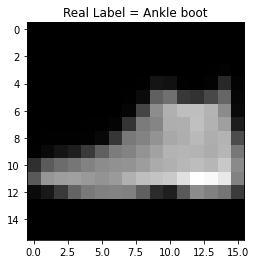

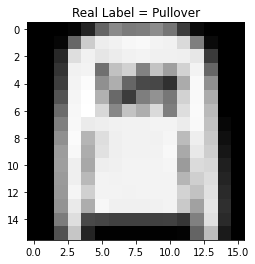

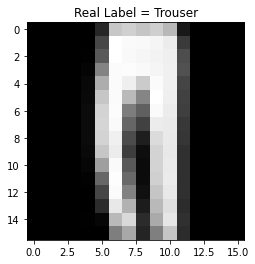

In [ ]:

for n,data_sample in enumerate(dataset_val):

    show_data(data_sample, IMAGE_SIZE)
    plt.show()
    if n==2:
        break 

<h2 id="Q2">Step 2: Create the Convolutional Neural Network</h2>


In the following cell, I'm defining the structure of my CNN.


In [ ]:
#Every PyTorch model must inherit from torch.nn.Module
#nn.Module has very useful functions for models
class CNN(nn.Module):
    
    # Constructor: (out_1: Output channels of first CNN Layer), (out_2: Output channels of second CNN Layer), (number_of_classes: Number of classes to detect)
    def __init__(self, out_1=16, out_2=32, number_of_classes=10):
        super().__init__()
        #Create first Convolution Layer with input of 1 channel (grayscale) and output of out_1 channels
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)

        #Initialize the weights of the first Convolution Layer with He initialization for Leaky ReLU activation
        nn.init.kaiming_uniform_(self.cnn1.weight, nonlinearity='relu')

        #Create Batch Normalization for first Convolution Layer
        self.conv1_bn = nn.BatchNorm2d(out_1)


        #Create Leaky ReLU activation
        self.leaky_relu = nn.LeakyReLU()

        #Create Max Pooling for first Convolution Layer
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        


        #Create second Convolution Layer with input of out_1 channels (from first layer) and output of out_2 channels
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)

        #Initialize the weights of the second Convolution Layer with He initialization for Leaky ReLU activation
        nn.init.kaiming_uniform_(self.cnn2.weight, nonlinearity='leaky_relu')

        #Create Batch Normalization for second Convolution Layer
        self.conv2_bn = nn.BatchNorm2d(out_2)

        #Create Max Pooling for second Convolution Layer
        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        #Create a fully connected layer for the CNN. The input shape is the flattened convolution output. If output is (3, 28, 28), input is 28 * 28 * 3.
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
    
    # Prediction (x is input)
    # The forward function is automatically called when we create an instance of the class and call it.
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.leaky_relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = self.leaky_relu(x)
        x = self.maxpool2(x)
        
        #Flattening cnn2's output and passing it into a fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Load training and test data with a batch size of 100.

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100 )
test_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=100 )

Create a CNN object and show the structure.


In [ ]:
import torchsummary as summary
model = CNN()

summary.summary(model, (1, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
       BatchNorm2d-2           [-1, 16, 16, 16]              32
         LeakyReLU-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]          12,832
       BatchNorm2d-6             [-1, 32, 8, 8]              64
         LeakyReLU-7             [-1, 32, 8, 8]               0
         MaxPool2d-8             [-1, 32, 4, 4]               0
            Linear-9                   [-1, 10]           5,130
Total params: 18,474
Trainable params: 18,474
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.07
Estimated Total Size (MB): 0.22
---------------------------------------------

Here, we're just creating the optimizer and criterion/cost function. We'll use Adam as our optimizer and Cross Entropy Loss as our cost function since we're classifying images. To find the best optimizer, learning rate, number of layers, and etc., you have to do <a href ="https://en.wikipedia.org/wiki/Hyperparameter_optimization#:~:text=In%20machine%20learning%2C%20hyperparameter%20optimization,typically%20node%20weights)%20are%20learned.">hyperparameter tuning<a><font color="black">. By tuning this network, I've achieved an 88% validation accuracy and a 92% training accuracy.<font>

In [ ]:
#Creating an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

#Use Cross Entropy Loss since this is a classification problem
criterion = nn.CrossEntropyLoss()

Here, I'm actually training the Classification Model.

In [ ]:
# To show a progress bar while training
from tqdm import tqdm

training_acc_list=[]
val_acc_list=[]
N_test=len(dataset_val)
N_train = len(dataset_train)
n_epochs=10

for epoch in range(n_epochs):
    #Count how many predictions were correct
    correct = 0

    print()
    print(f"Epoch no. {epoch}")
    #Put model into training mode (uses Dropout if there are Dropout layers)
    model.train()
    #Loop over each sample in the dataloaders.
    for x, y in tqdm(train_loader):
        #Zero the optimizer gradients (PyTorch requires this.)
        optimizer.zero_grad()
        #Make a prediction
        y_hat = model(x)
        #Calculate the loss with the criterion
        loss = criterion(y_hat, y)
        #Initiate backpropagation/calculate derivatives of parameters with respect to the loss.
        loss.backward()
        #Update parameters
        optimizer.step()
        
        #Update correct counter
        #Grab the index of the AI's highest probability guess (Each output of model(x) is a tensor of probabilities) 
        correct += (torch.argmax(y_hat, 1) == y).sum().item()
        
    #Calculate accuracy
    accuracy = correct / N_train
    print("Training accuracy: " + str(accuracy))
    training_acc_list.append(accuracy)

    correct=0
    
    #Put model into validation mode (turns off Dropout if there are Dropout layers)
    model.eval()
    for x_test, y_test in test_loader:
        #Make a prediction
        z = model(x_test)
        #Grab the index of the AI's highest probability guess (Each output of model(x) is a tensor of probabilities) 
        y_hat = torch.argmax(z, 1)
        #Update correct counter if the prediction was correct
        correct += (y_hat == y_test).sum().item()
    accuracy = correct / N_test
    print("Validation accuracy: " + str(accuracy))
    val_acc_list.append(accuracy)
    


  0%|          | 3/600 [00:00<00:26, 22.21it/s]


Epoch no. 0



100%|██████████| 600/600 [00:29<00:00, 20.55it/s]


Training accuracy: 0.8349333333333333



  0%|          | 3/600 [00:00<00:26, 22.36it/s]

Validation accuracy: 0.8604

Epoch no. 1



100%|██████████| 600/600 [00:30<00:00, 19.93it/s]


Training accuracy: 0.8789



  0%|          | 3/600 [00:00<00:26, 22.91it/s]

Validation accuracy: 0.8749

Epoch no. 2



100%|██████████| 600/600 [00:30<00:00, 19.84it/s]


Training accuracy: 0.8910666666666667



  0%|          | 3/600 [00:00<00:27, 21.93it/s]

Validation accuracy: 0.877

Epoch no. 3



100%|██████████| 600/600 [00:31<00:00, 19.32it/s]


Training accuracy: 0.8991



  0%|          | 2/600 [00:00<00:30, 19.48it/s]

Validation accuracy: 0.8804

Epoch no. 4



100%|██████████| 600/600 [00:31<00:00, 19.16it/s]


Training accuracy: 0.9047333333333333



  0%|          | 3/600 [00:00<00:27, 21.87it/s]

Validation accuracy: 0.8829

Epoch no. 5



100%|██████████| 600/600 [00:31<00:00, 19.05it/s]


Training accuracy: 0.90935



  0%|          | 2/600 [00:00<00:35, 16.73it/s]

Validation accuracy: 0.883

Epoch no. 6



100%|██████████| 600/600 [00:32<00:00, 18.61it/s]


Training accuracy: 0.9137666666666666



  0%|          | 3/600 [00:00<00:27, 21.54it/s]

Validation accuracy: 0.8852

Epoch no. 7



100%|██████████| 600/600 [00:32<00:00, 18.50it/s]


Training accuracy: 0.9179166666666667



  0%|          | 3/600 [00:00<00:28, 20.59it/s]

Validation accuracy: 0.8807

Epoch no. 8



100%|██████████| 600/600 [00:32<00:00, 18.58it/s]


Training accuracy: 0.9217333333333333



  0%|          | 3/600 [00:00<00:28, 21.21it/s]

Validation accuracy: 0.878

Epoch no. 9



100%|██████████| 600/600 [00:32<00:00, 18.32it/s]


Training accuracy: 0.92425
Validation accuracy: 0.8767


Plotting the accuracies.

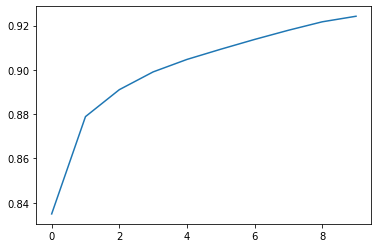

In [ ]:
plt.plot(training_acc_list)

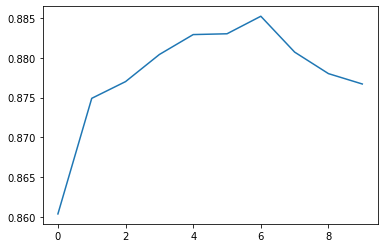

In [ ]:
plt.plot(val_acc_list)

In [ ]:
#We can save our model's weights by running the following:
torch.save(model.state_dict(), "MNIST.pth")

In [ ]:
#We can load the model's weights by running the following:
model.load_state_dict(torch.load("MNIST.pth"))

<All keys matched successfully>

Testing Out The Model


AI's Prediction: Sneaker


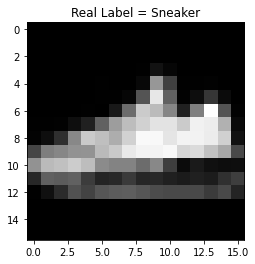

In [ ]:
import random
model.eval()
randomIndex = random.randint(0, len(dataset_val) - 1)
test = dataset_val[randomIndex]
show_data(test, IMAGE_SIZE)
# Turn image of (C, H, W) into (B, C, H, W) to pass into the model
# Take the index of the highest probability from the output tensor and grab the corresponding classification
print("AI's Prediction: " + labels[torch.argmax(model(test[0].view(-1, 1, 16, 16)), 1)])


<hr>


Thanks for making it this far! I hope you now have a basic foundation for creating models in PyTorch!

To further improve your PyTorch skills, it's integral to build projects and continue practicing it. A good way to do this is through hackathons such as HackMIT or Facebook's AI hackathons. If you're a high school student, you can attend Explore Hacks, which is taking place in 2021 from July 23rd - July 25th. We hope to see you there!

For more information, please go to https://explorehacks.org

<a href="https://explorehacks.org">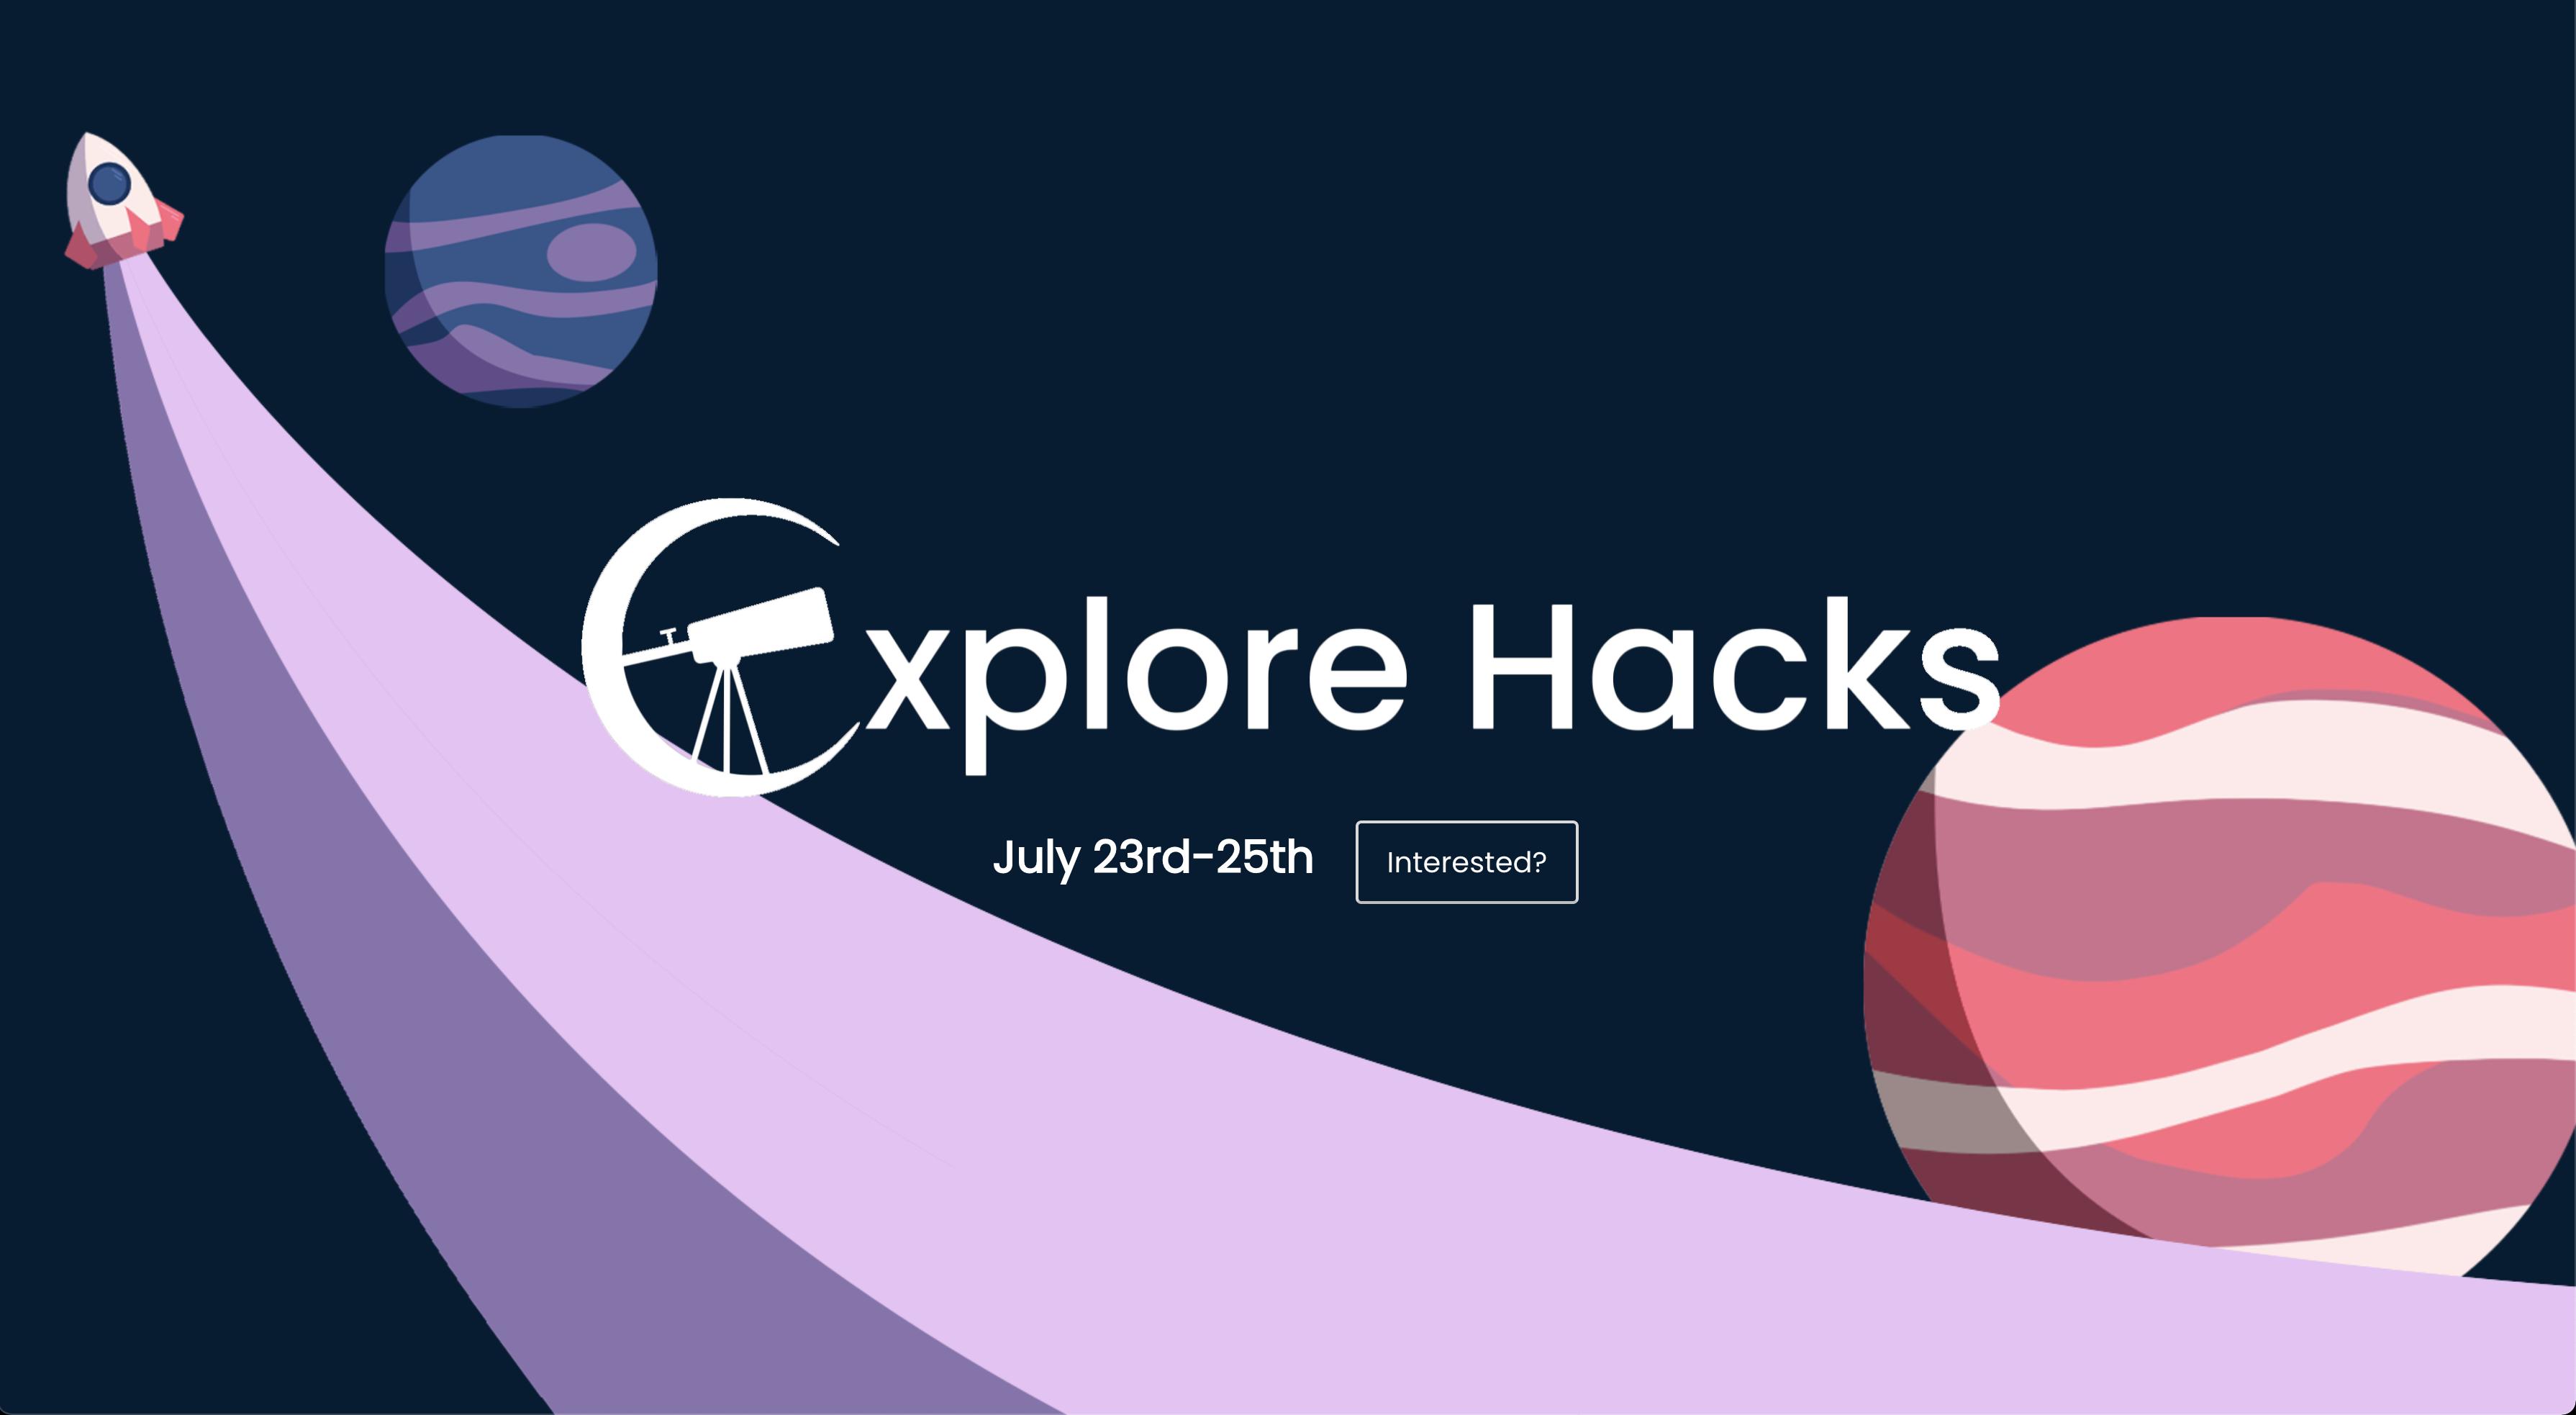</a>

<hr>

Dataset: https://github.com/zalandoresearch/fashion-mnist

Notebook adapted from IBM's PyTorch course on Coursera


<a href="https://www.coursera.org/learn/deep-neural-networks-with-pytorch/home/welcome">PyTorch Course By IBM<a>

Author:
Leo Xu



<hr>